# Deep Learning Assessment 2020
# Family Guy Character Classifier

## Heather Logan (2128536L)



In [0]:
# Imports 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import itertools

from torchvision import datasets, transforms, models
from collections import OrderedDict

from os import listdir
from PIL import Image 

import glob
import imageio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import load_mnist, train, evaluate, CNN

from sklearn.metrics import classification_report


In [0]:
from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = 'drive/My Drive/characters2'

trainpath = path + '/train'
testpath = path + '/test'


# Dataset


For this exercise, I chose to develop a model to classify images of Family Guy characters, a current cartoon television program, after taking inspiration from a Towards Data Science article describing a Simpsons classifier. (https://medium.com/alex-attia-blog/the-simpsons-character-recognition-using-keras-d8e1796eae36)

The dataset consists of 9 characters, the 6 main characters: 
Peter, Lois, Brian, Stewie, Meg and Chris Griffin, and secondary characters Joe Swanson, Glenn Quagmire and Cleveland Brown. 

To create the dataset, I wrote a script to scrape images relating to each character from the Bing search engine, using queries such as ‘[character_name] + [cartoon|face|happy|sad|laughing|angry]’ to generate a larger number of unique results.
There was an issue with duplicates, unrelated images, images with multiple characters, and so the dataset had to be manually filtered and cropped to give single character images. 

Another issue is that it was more difficult to retrieve unique images of secondary characters than the main characters, resulting in imbalanced classes which can bias the classifier. To alleviate this slightly, I captured images from short clips of the character. 
This is not an ideal method for a small dataset as the frames are more be similar to each other than the extracted Bing images, however there was no other data source that could be used in feasible time to balance classes.

After this, there was still a slight class imbalance between the classes, so a Weighted Random Sampler was used (using code from: https://discuss.pytorch.org/t/balanced-sampling-between-classes-with-torchvision-dataloader/2703)
This technique helps to balance classes by sampling with weighted probabilities to reduce the bias of larger classes. 


Challenges of the task 
* While the cartoon data are flat-images and may be likely to be more easily learned by a classifier, there are some challenges faced:
* The illustrations of each character follow a similar style, (although some have distinctive features such as face shape, chin) 
* Characters wear the same outfits most of the time, however sometimes appear in costumes or different outfits, which could potentially confuse a classifier. 

The topic was chosen as an interesting exploration of neural nets on a favourite cartoon show, however possible future uses may include character recognition from video clips, character motion tracking, database creation from video clips. 

Due to the limited size of the dataset, the test set was also used for validation, rather than two separate sets. The trainng sets consist of over 100 images per character, and around 20-25 images per character in the test set.




In [0]:

# Define transforms for the training, validation, and testing sets

# only to tensor and resizes
transform1 = transforms.Compose([ transforms.Resize((224,224)),
                                          transforms.ToTensor(), 
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])


transform2 = transforms.Compose([transforms.RandomRotation(50), 
                                transforms.Resize((224,224)),
                                          transforms.ToTensor(), 
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])


transform3 = transforms.Compose([transforms.RandomCrop(224, pad_if_needed=True),
                                 transforms.Resize((224,224)),
                                          transforms.ToTensor(), 
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])


testing_transforms = transforms.Compose([transforms.Resize((224,224)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])



train_data = datasets.ImageFolder(trainpath, transform=transform1) + datasets.ImageFolder(trainpath, transform=transform2) + datasets.ImageFolder(trainpath, transform=transform3) 
test_data = datasets.ImageFolder(testpath, transform=testing_transforms)

# data loader randomises and creates batches|

test_loader = torch.utils.data.DataLoader(test_data, batch_size=60)
validate_loader = test_loader # TODO - 

Text(0.5, 1.0, 'Stewie Griffin')

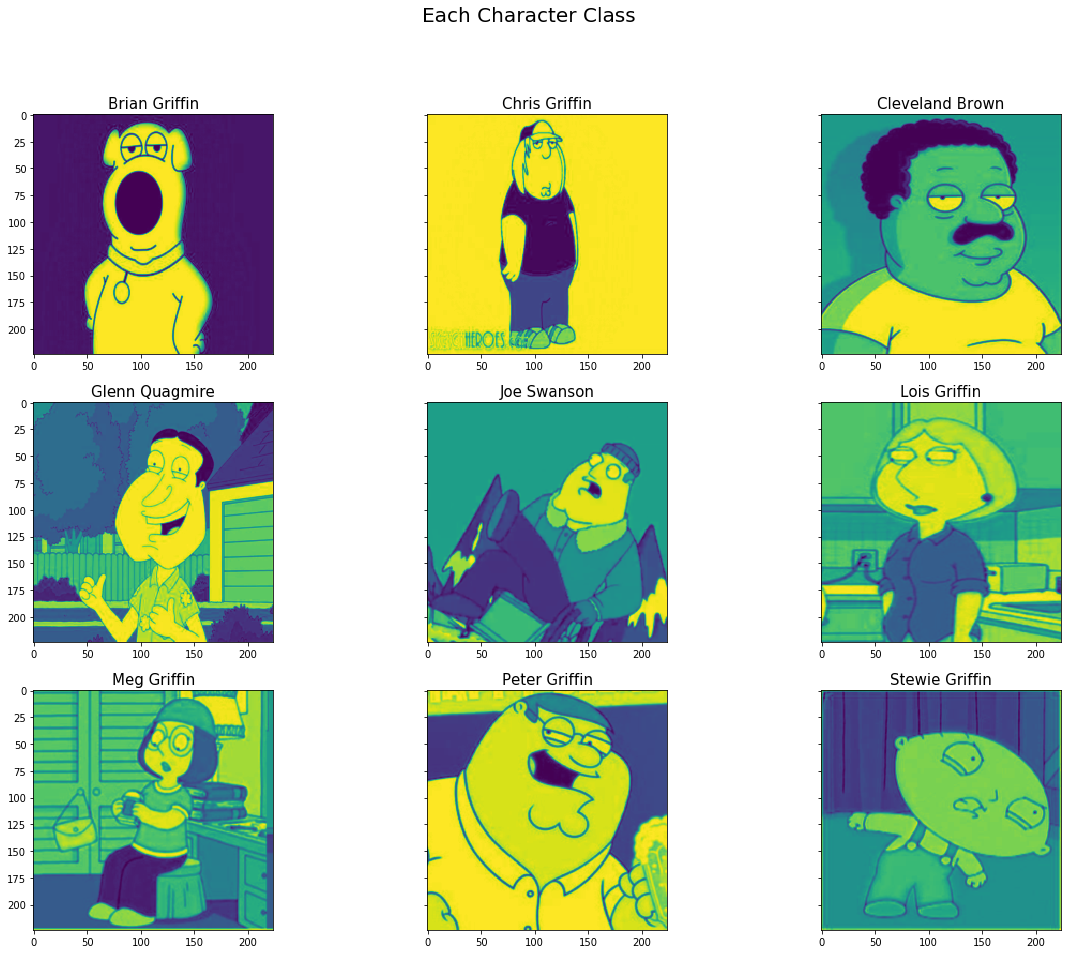

In [0]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, sharey=True, figsize=(20,15))

unaug_train_data = datasets.ImageFolder(trainpath, transform=transform1)

f.suptitle('Each Character Class', fontsize=20)

ax1.imshow((unaug_train_data[6][0][0]))
ax1.set_title('Brian Griffin', fontsize=15)

ax2.imshow((unaug_train_data[170][0][0]))
ax2.set_title('Chris Griffin', fontsize=15)

ax3.imshow((unaug_train_data[213][0][0]))
ax3.set_title('Cleveland Brown', fontsize=15)

ax4.imshow((unaug_train_data[310][0][0]))
ax4.set_title('Glenn Quagmire', fontsize=15)

ax5.imshow((unaug_train_data[411][0][0]))
ax5.set_title('Joe Swanson', fontsize=15)

ax6.imshow((unaug_train_data[510][0][0]))
ax6.set_title('Lois Griffin', fontsize=15)

ax7.imshow((unaug_train_data[610][0][0]))
ax7.set_title('Meg Griffin', fontsize=15)

ax8.imshow((unaug_train_data[710][0][0]))
ax8.set_title('Peter Griffin', fontsize=15)

ax9.imshow((unaug_train_data[819][0][0]))
ax9.set_title('Stewie Griffin', fontsize=15)



In [0]:
idx_to_class = {0:'brian_griffin',
                1:'chris_griffin',
                2:'cleveland_brown',
                3:'glenn_quagmire',
                4:'joe_swanson',
                5:'lois_griffin',
                6:'meg_griffin',
                7:'peter_griffin',
                8:'stewie_griffin' }

NUM_EPOCHS = 20
num_classes = len(test_data.classes)


<Figure size 432x288 with 0 Axes>

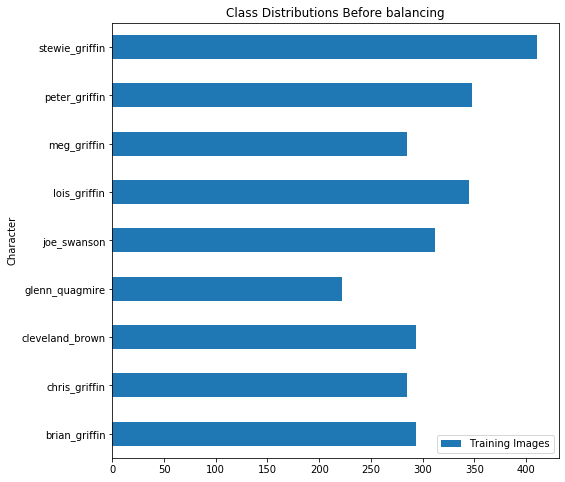

In [0]:
from collections import Counter

classcounts = Counter()

for i,label in train_loader.dataset:
  classcounts[idx_to_class[label]] += 1

plt.figure()
df = pd.DataFrame(classcounts.items(), columns=['Character', 'Training Images'])
df.plot.barh(x='Character', y='Training Images', figsize=(8,8), title='Class Distributions Before balancing')

# Data Augmentation


With data collection being a slow process, it was necessary to extend the current dataset in order to effectively train the classifier. Data augmentation involves applying some alteration to a current image, creating another data point. 

As I had a relatively large number of classes I did not want to apply too many transformations as limited processing power was available and training was slow. 

As the images are 2-dimensional cartoons, I thought changing the colour/brightness would not be very effective. 

The colours distorted to yellow/green when uploaded from Google Drive, which I was unable to fix. 
Instead I applied a random rotation, and a random zoom to the images, of which examples samples can be seen below. 
This increased the dataset size by a factor of 3. 

** When cleaning up this section after completing all resutls, the random sampler was not working as it did before, which I could not debug. I've attached an image from an old backup to show that the remainder of the code was run on a balanced dataset. ** 

<Figure size 432x288 with 0 Axes>

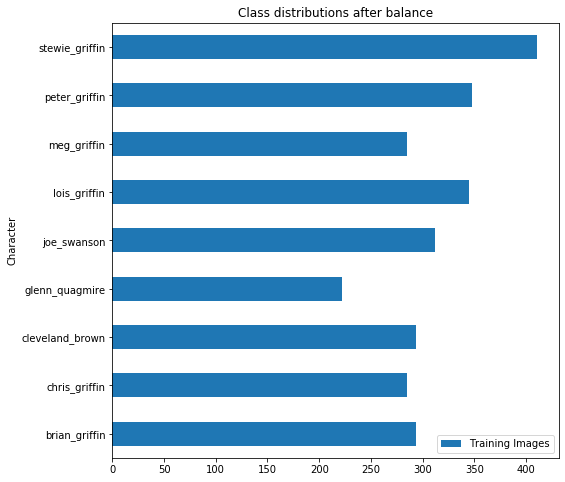

In [0]:
from collections import Counter

def make_weights_for_balanced_classes(images, nclasses):   

    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight 


weights = make_weights_for_balanced_classes(train_data, len(test_data.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
                                                                                
train_loader = torch.utils.data.DataLoader(train_data, batch_size=60,                            
                                                             sampler=sampler, pin_memory=True) 

classcounts2 = Counter()
for i, label in train_loader.dataset:
  classcounts2[idx_to_class[label]] +=1

plt.figure()
df = pd.DataFrame(classcounts2.items(), columns=['Character', 'Training Images'])
df.plot.barh(x='Character', y='Training Images', figsize=(8,8), title='Class distributions after balance')


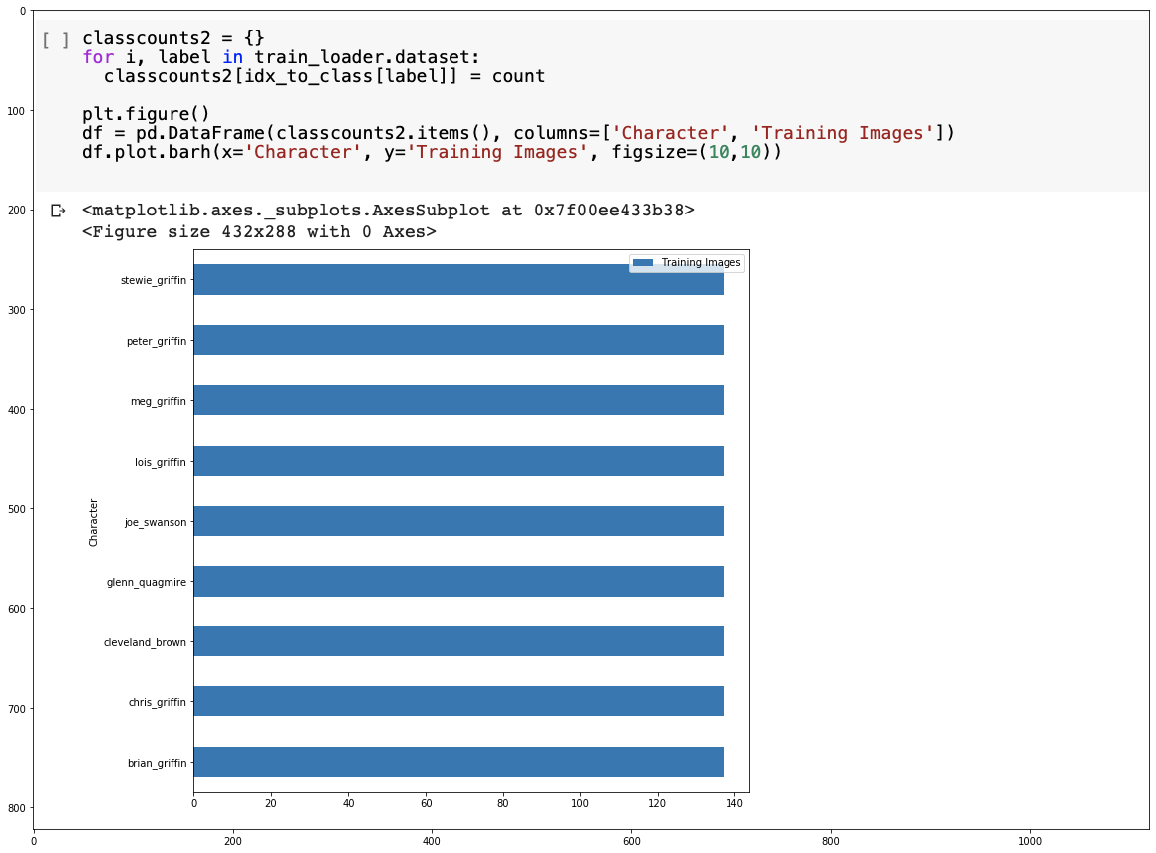

In [0]:
# SCREENSHOT FROM OLD BACKUP SHOWING BALANCED DATASET - ENCOUNTERED ISSUE AFTER COMPLETING MODEL TRAINING

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,20))
img=mpimg.imread('drive/My Drive/SCREENSHOT1.png')
imgplot = plt.imshow(img)
plt.show()



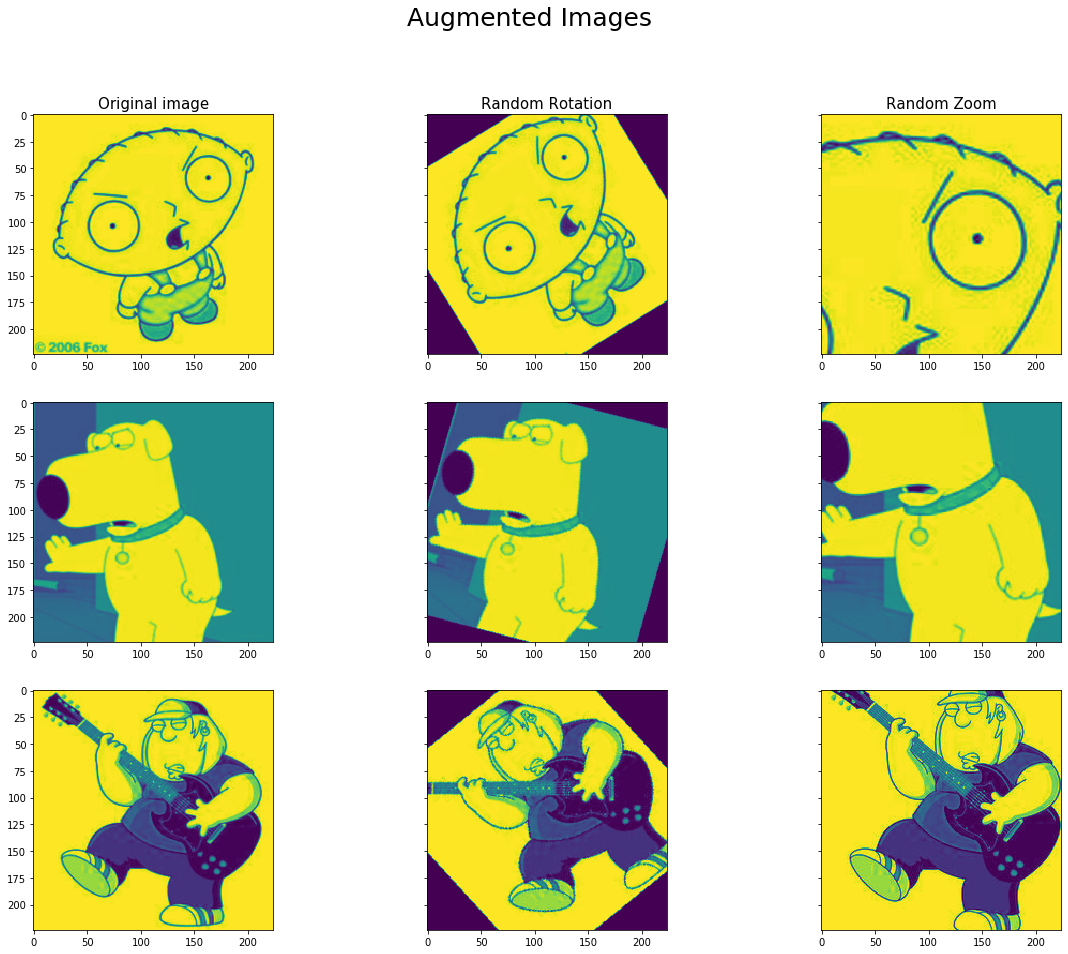

In [0]:
x, y, z = 810,51, 99
l = int(len(train_data)/3)

f, ((ax1, ax2, ax3), (ax5, ax6, ax7), (ax9, ax10, ax11)) = plt.subplots(3, 3, sharey=True, figsize=(20,15))
f.suptitle('Augmented Images',  fontsize=25)
ax1.imshow((train_data[x][0][0]))
ax1.set_title('Original image', fontsize=15)
ax2.imshow((train_data[x+l][0][0]))
ax2.set_title('Random Rotation' , fontsize=15)
ax3.imshow((train_data[x+(2*l)][0][0]))
ax3.set_title('Random Zoom',  fontsize=15)



ax5.imshow(train_data[y][0][0])
ax6.imshow(train_data[y+l][0][0])
ax7.imshow(train_data[y+2*l][0][0])

# ax8.imshow(zoom_in(example_img2))

ax9.imshow(train_data[z][0][0])
ax10.imshow(train_data[z+l][0][0])
ax11.imshow(train_data[z+(2*l)][0][0])

# ax12.imshow(zoom_in(example_img3))


# Candidate Model Architectures

4 pretrained models were used on the dataset without any hyperparameter tuning, with a comparison to a baseline 2 layer network. 


* Baseline = Simple 2 layer dense neural network with softmax activation function 
* VGG16
* Resnet 50 
* SqueezeNet 
* Densenet 


The VGG16, Resnet 50 and Densenet models performed very well on the data, achieving over 80% accuracy. 

The Squeezenet model performed very poorly across all epochs and so was discarded from consideration. 

The VGG16 model had reasonable accuracy howvever a high loss. 
Resnet50 had similar accuracy to the best performing DenseNet, but had a less consistent loss from epoch to epoch. 

# Assessing Candidates

When assessing the candidates, pre-trained the outer layer was reshaped to fit the classification problem, and Cross-Entropy Loss was used against the test/validation set, and the accuracy was measured, before further finetuning.

Densenet was chosen as the best candidate model for further tuning as it consistenty had the lowest loss and highest accuracy across epochs. 






In [0]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [0]:
def save_model(model, name):
  model = model
  model_save_name = name + '.pt'
  path = 'drive/My Drive/{}'.format(model_save_name)
  torch.save(model.state_dict(), path)

In [0]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(3*224*224, 100)  
        self.fc2 = nn.Linear(100, num_classes)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x)

net = Net()
print(net)

# run the main training loop

baseline_accuracies = [] 
baseline_losses = [] 

correct, total = 0,0 
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(NUM_EPOCHS):

    for batch_idx, (data, target) in enumerate(train_loader):        
        data = Variable(data)
        target = Variable(target)

        data = data.view(-1, 3*224*224)
        net.zero_grad()

        net_out = net(data)

        for i, v in enumerate(net_out):
          if torch.argmax(v)==target[i]:
            correct += 1
          total += 1

        # loss = F.nll_loss(net_out, target)

        loss = F.cross_entropy(net_out, target)

        loss.backward()
        optimizer.step()
        
    baseline_accuracies.append(correct/total)
    baseline_losses.append(loss.item())
    print('Epoch, ', epoch+1,' Accuracy:', correct/total, ' Cross Entropy Loss: ', loss.item())



Net(
  (fc1): Linear(in_features=150528, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=9, bias=True)
)


In [0]:
save_model(net, 'baseline')

# For Pretrained Models

In [0]:
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [0]:
def plot_performance(val_loss, accuracy_array, title, train_loss=None):

  epochs = np.arange(len(val_loss)) 
  f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))

  if train_loss:
    ax1.plot(epochs, train_loss, 'g.-', label='Training Loss')

  ax1.plot(epochs, val_loss, 'r.-', label='Validation Loss')

  ax1.set_title('Cross Entropy Loss')
  ax1.set_xlabel('Epochs')
  ax1.legend()

  ax2.set_title('Validation Accuray')
  ax2.set_xlabel('Epochs')
  ax2.plot(epochs, accuracy_array, 'm.-')

  f.suptitle(title, fontsize=15)
  ax1.grid(True)
  ax2.grid(True)

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()

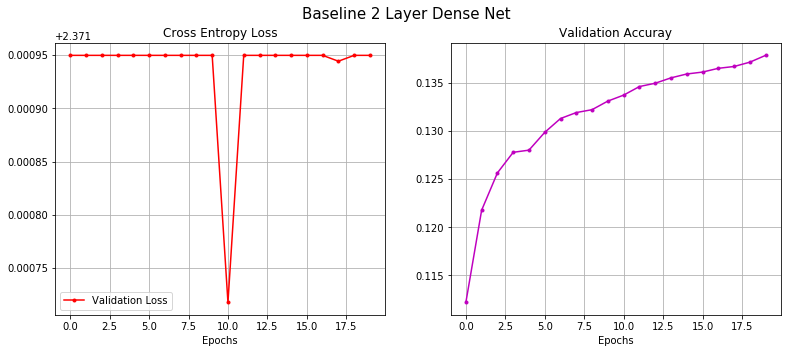

In [0]:
plot_performance(baseline_losses, baseline_accuracies, "Baseline 2 Layer Dense Net")

In [0]:
def train_model(model, num_epochs, learning_rate=0.01, penalty=0):
  
  train_losses = []
  val_losses = [] 
  accuracies = [] 

  y_true = []
  y_pred = []

  steps = 0
  print_every = 40

  # criterion = nn.NLLLoss()
  criterion = nn.CrossEntropyLoss()
  
  try:
    optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate, weight_decay=penalty)
  except:
    optimizer = optim.Adam(model.classifier.parameters(), lr=learning_rate, weight_decay=penalty)

  model.to(device)

  for e in range(num_epochs):
        
    model.train()
    
    running_loss = 0
    
    for images, labels in iter(train_loader):
        
      steps += 1
        
      images, labels = images.to('cuda'), labels.to('cuda')
        
      optimizer.zero_grad()
        
      output = model.forward(images)
      loss = criterion(output, labels)
      loss.backward()
      optimizer.step()
        
      running_loss += loss.item()
                        
      model.eval()


      if steps % print_every == 0:
                
        model.eval()
                
        with torch.no_grad():
          validation_loss, accuracy = validation(model, validate_loader, criterion)
        
        train_losses.append(running_loss/print_every)
        val_losses.append(validation_loss/len(validate_loader))
        accuracies.append(accuracy/len(validate_loader))
        y_true.append(labels)
        y_pred.append(torch.argmax(output, 1))

        print("Epoch: {}/{}.. ".format(e+1, num_epochs),
                          "Training Loss: {:.5f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.5f}.. ".format(validation_loss/len(validate_loader)),
                          "Validation Accuracy: {:.5f}".format(accuracy/len(validate_loader)))
            
        running_loss = 0
        model.train()

    new_y_true = [i.item() for i in list(itertools.chain.from_iterable(y_true))]
    new_y_pred = [i.item() for i in list(itertools.chain.from_iterable(y_pred))]

    cm = confusion_matrix(new_y_true, new_y_pred)

  return train_losses, val_losses, accuracies, cm, (new_y_true, new_y_pred)

## 1. VGG16 Model

In [0]:
vgg_model = models.vgg16(pretrained=True)

# freeze layers
for parameter in vgg_model.parameters():
    parameter.requires_grad = False

# reshape classifier to data
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('fc2', nn.Linear(5000, num_classes)),
                                        ('output', nn.LogSoftmax(dim=1))]))

vgg_model.classifier = classifier

# TODO - temporary test_loa
validate_loader = test_loader

print(vgg_model)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
vgg_train_losses, vgg_val_losses, vgg_accuracies, vgg_cm= train_model(vgg_model, num_epochs=20)
save_model(vgg_model, 'vgg16')

Epoch: 1/20..  Training Loss: 11073.80676..  Validation Loss: 5401.78206..  Validation Accuracy: 0.09646
Epoch: 2/20..  Training Loss: 3586.63082..  Validation Loss: 1893.65759..  Validation Accuracy: 0.44444
Epoch: 3/20..  Training Loss: 2863.59516..  Validation Loss: 707.17114..  Validation Accuracy: 0.62626
Epoch: 4/20..  Training Loss: 1122.70473..  Validation Loss: 709.14984..  Validation Accuracy: 0.67929
Epoch: 5/20..  Training Loss: 1060.54578..  Validation Loss: 1003.61023..  Validation Accuracy: 0.68889
Epoch: 6/20..  Training Loss: 597.58510..  Validation Loss: 394.05406..  Validation Accuracy: 0.79646
Epoch: 7/20..  Training Loss: 533.32108..  Validation Loss: 681.01565..  Validation Accuracy: 0.74141
Epoch: 8/20..  Training Loss: 232.22659..  Validation Loss: 459.24182..  Validation Accuracy: 0.84646
Epoch: 9/20..  Training Loss: 206.06165..  Validation Loss: 565.38185..  Validation Accuracy: 0.77778
Epoch: 10/20..  Training Loss: 184.56336..  Validation Loss: 461.39343.. 

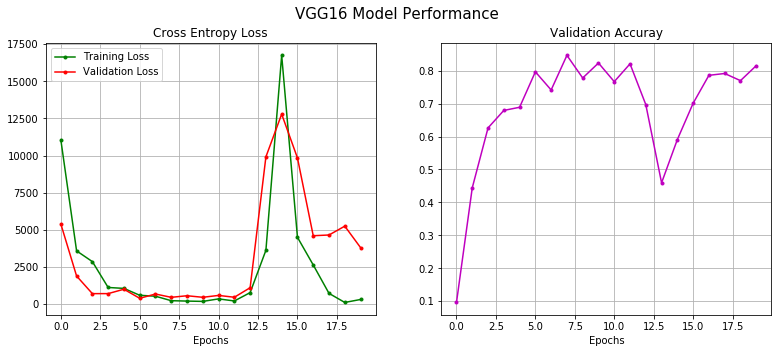

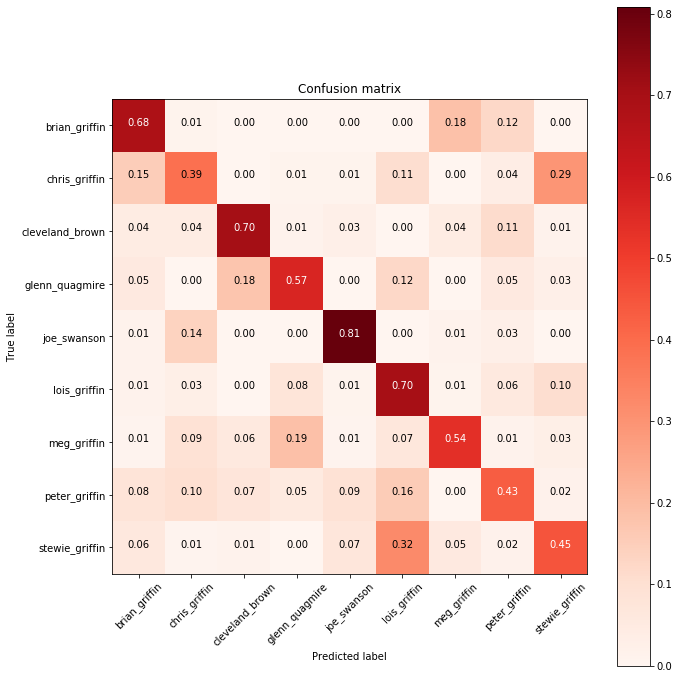

In [0]:
plot_performance(vgg_val_losses, vgg_accuracies, "VGG16 Model Performance", vgg_train_losses)
plot_confusion_matrix(vgg_cm, test_data.classes, normalize=True)

## 2. Resnet50 Model

In [0]:
resnet_model = models.resnet50(pretrained=True)

# freeze layers
for parameter in resnet_model.parameters():
    parameter.requires_grad = False

resnet_model.fc= nn.Linear(2048, num_classes)

resnet_train_loss, resnet_val_loss, resnet_accuracy, resnet_cm = train_model(resnet_model, NUM_EPOCHS)
save_model(resnet_model, 'resnet')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Epoch: 1/20..  Training Loss: 15.35813..  Validation Loss: 4.33014..  Validation Accuracy: 0.28636
Epoch: 2/20..  Training Loss: 5.94842..  Validation Loss: 1.93941..  Validation Accuracy: 0.49545
Epoch: 3/20..  Training Loss: 3.85645..  Validation Loss: 2.42965..  Validation Accuracy: 0.67323
Epoch: 4/20..  Training Loss: 2.35070..  Validation Loss: 1.46010..  Validation Accuracy: 0.73939
Epoch: 5/20..  Training Loss: 2.90042..  Validation Loss: 1.05590..  Validation Accuracy: 0.75505
Epoch: 6/20..  Training Loss: 1.68376..  Validation Loss: 0.62675..  Validation Accuracy: 0.87121
Epoch: 7/20..  Training Loss: 1.92546..  Validation Loss: 0.63033..  Validation Accuracy: 0.84192
Epoch: 8/20..  Training Loss: 1.53173..  Validation Loss: 0.73974..  Validation Accuracy: 0.82525
Epoch: 9/20..  Training Loss: 1.62566..  Validation Loss: 0.86138..  Validation Accuracy: 0.81616
Epoch: 10/20..  Training Loss: 1.37426..  Validation Loss: 1.12710..  Validation Accuracy: 0.77172
Epoch: 11/20..  T

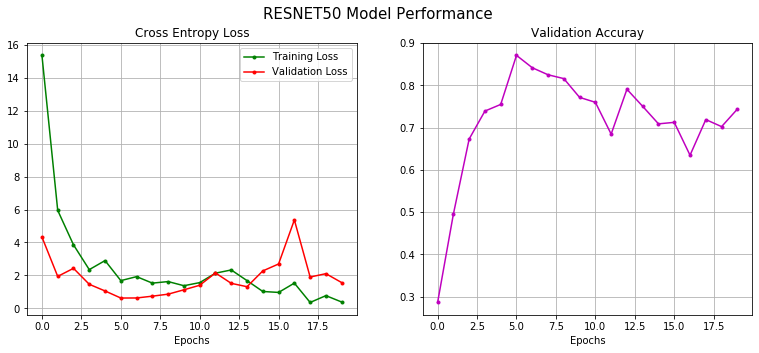

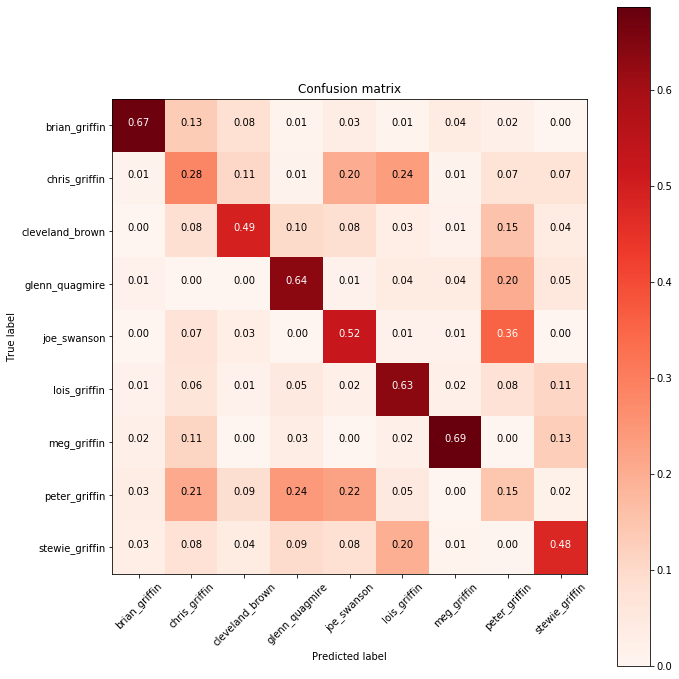

In [0]:
plot_performance(resnet_val_loss, resnet_accuracy, 'RESNET50 Model Performance', resnet_train_loss)
plot_confusion_matrix(resnet_cm, test_data.classes, normalize=True)

## 3. SqueezeNet

In [0]:
squeeze_model = models.squeezenet1_0(pretrained=True)

# freeze layers
for parameter in squeeze_model.parameters():
    parameter.requires_grad = False

squeeze_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

squeeze_train_loss, squeeze_val_loss, squeeze_accuracy, squeeze_cm = train_model(squeeze_model, NUM_EPOCHS)
save_model(squeeze_model, 'squeezenet')

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/checkpoints/squeezenet1_0-a815701f.pth



Epoch: 1/20..  Training Loss: 2.62327..  Validation Loss: 2.19679..  Validation Accuracy: 0.14444
Epoch: 2/20..  Training Loss: 2.14215..  Validation Loss: 2.19588..  Validation Accuracy: 0.14444
Epoch: 3/20..  Training Loss: 2.08619..  Validation Loss: 2.18100..  Validation Accuracy: 0.16667
Epoch: 4/20..  Training Loss: 2.01982..  Validation Loss: 2.06582..  Validation Accuracy: 0.14444
Epoch: 5/20..  Training Loss: 1.92326..  Validation Loss: 2.02674..  Validation Accuracy: 0.17778
Epoch: 6/20..  Training Loss: 1.82734..  Validation Loss: 2.00104..  Validation Accuracy: 0.17778
Epoch: 7/20..  Training Loss: 1.76337..  Validation Loss: 1.99120..  Validation Accuracy: 0.18333
Epoch: 8/20..  Training Loss: 1.69520..  Validation Loss: 1.98800..  Validation Accuracy: 0.18889
Epoch: 9/20..  Training Loss: 1.63859..  Validation Loss: 1.98560..  Validation Accuracy: 0.21111
Epoch: 10/20..  Training Loss: 1.57583..  Validation Loss: 1.97912..  Validation Accuracy: 0.20000
Epoch: 11/20..  Tr

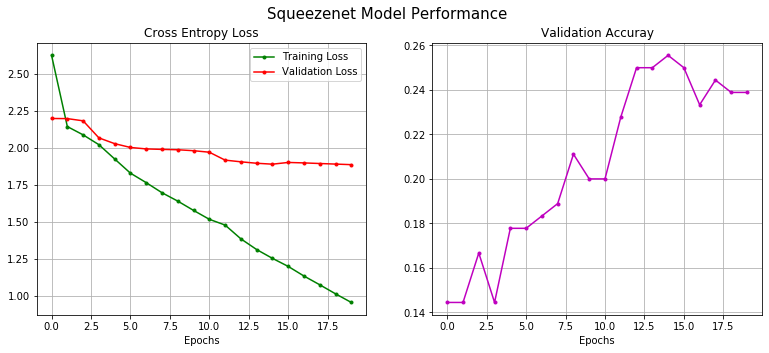

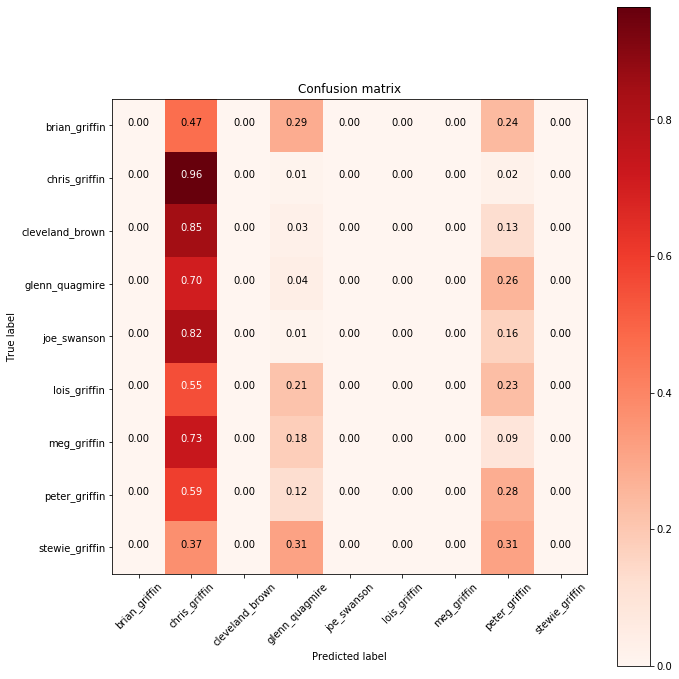

In [0]:
plot_performance(squeeze_val_loss, squeeze_accuracy, 'Squeezenet Model Performance', squeeze_train_loss)
plot_confusion_matrix(squeeze_cm, test_data.classes, normalize=True)

## 4. DenseNet

In [0]:
dense_model = models.densenet121(pretrained=True)

for parameter in squeeze_model.parameters():
    parameter.requires_grad = False

dense_model.classifier = nn.Linear(1024, num_classes)

dense_train_loss, dense_val_loss, dense_accuracy, dense_cm = train_model(dense_model, NUM_EPOCHS)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth



Epoch: 1/20..  Training Loss: 7.71038..  Validation Loss: 1.62779..  Validation Accuracy: 0.54848
Epoch: 2/20..  Training Loss: 2.49184..  Validation Loss: 0.95004..  Validation Accuracy: 0.70707
Epoch: 3/20..  Training Loss: 1.48317..  Validation Loss: 0.82034..  Validation Accuracy: 0.75909
Epoch: 4/20..  Training Loss: 0.99599..  Validation Loss: 0.59241..  Validation Accuracy: 0.75960
Epoch: 5/20..  Training Loss: 0.90487..  Validation Loss: 0.42953..  Validation Accuracy: 0.84899
Epoch: 6/20..  Training Loss: 0.89489..  Validation Loss: 0.45580..  Validation Accuracy: 0.81010
Epoch: 7/20..  Training Loss: 0.73861..  Validation Loss: 0.39237..  Validation Accuracy: 0.87374
Epoch: 8/20..  Training Loss: 0.82232..  Validation Loss: 0.51588..  Validation Accuracy: 0.85152
Epoch: 9/20..  Training Loss: 0.76158..  Validation Loss: 0.46780..  Validation Accuracy: 0.85152
Epoch: 10/20..  Training Loss: 0.75265..  Validation Loss: 0.42964..  Validation Accuracy: 0.87929
Epoch: 11/20..  Tr

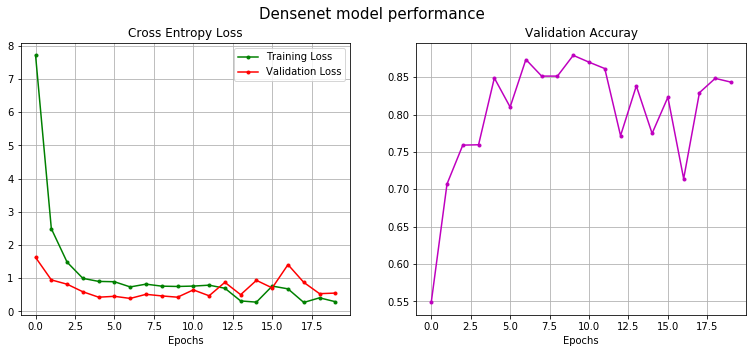

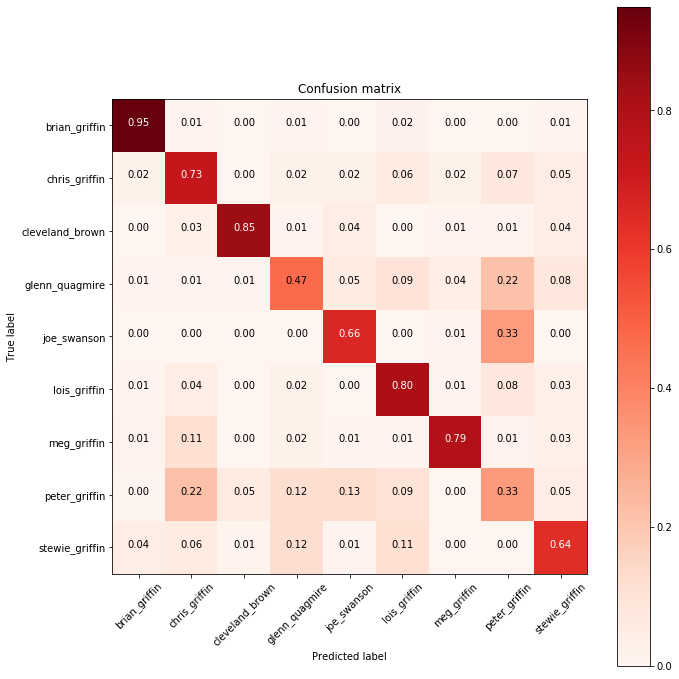

In [0]:
plot_performance(dense_val_loss, dense_accuracy, 'Densenet model performance', dense_train_loss)
plot_confusion_matrix(dense_cm, test_data.classes, normalize=True)

# Performance Comparison of Candidate Models

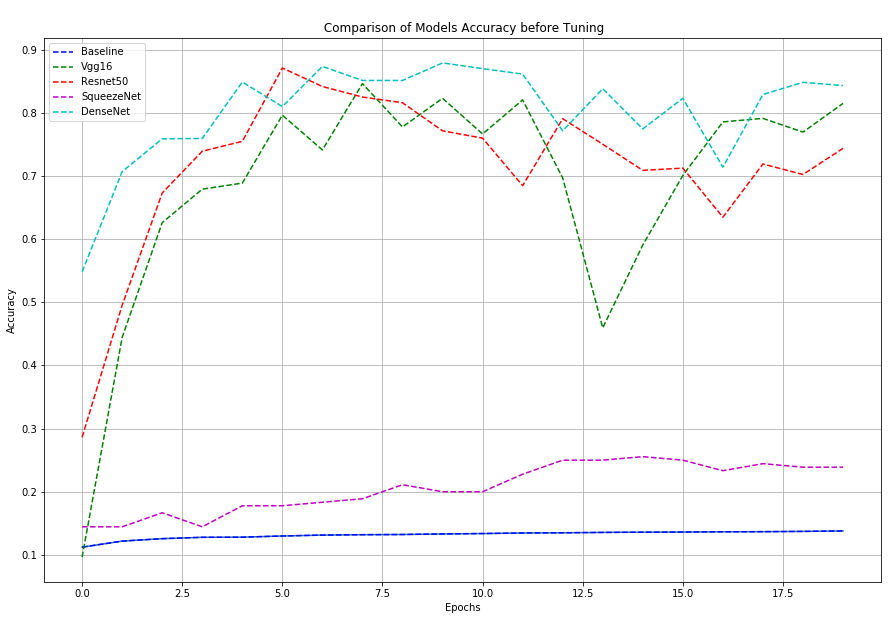

In [0]:
plt.figure(figsize=(15,10))
plt.plot(baseline_accuracies, )
epochs = np.arange(len(baseline_accuracies))
plt.plot(baseline_accuracies, 'b--', label='Baseline')
plt.plot(vgg_accuracies, 'g--', label='Vgg16')
plt.plot(resnet_accuracy, 'r--', label='Resnet50')
plt.plot(squeeze_accuracy, 'm--', label='SqueezeNet')
plt.plot(dense_accuracy, 'c--', label='DenseNet')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('\n Comparison of Models Accuracy before Tuning')
plt.legend()

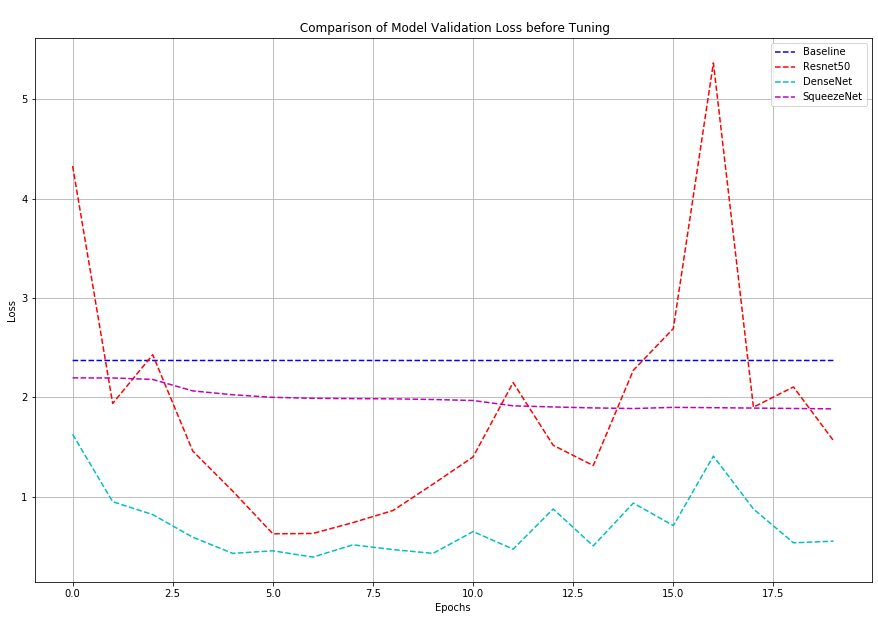

In [0]:
plt.figure(figsize=(15,10))
epochs = np.arange(len(baseline_accuracies))
plt.plot(baseline_losses, 'b--', label='Baseline')
# plt.plot(vgg_, 'g--', label='Vgg16')
plt.plot(resnet_val_loss, 'r--', label='Resnet50')
plt.plot(dense_val_loss, 'c--', label='DenseNet')
plt.plot(squeeze_val_loss, 'm--', label='SqueezeNet')
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('\n Comparison of Model Validation Loss before Tuning')
plt.legend()

# Hyperparameter Tuning and Regularisation

### The 4 pretrained models show comparable performance in terms of accuracy, with Densenet outperforming the others across most epoch's, followed by Resnet50. The cross entropy loss curves for the Densenet models is also smoother significantly lower than the rest.

### The finetuning will focus on the learning rate of the optimizer and the number of unfrozen layers. 

### Regularisation methods used were adjustments of the models dropout, and applying L2 Regularisation

### Due to the large complexity of grid search and cross-validation techniques, a manual range of values for each hyperparameter was used. 


## 1. Learning Rate

### Manual Search was used on a small number of vairants for the learning late due to the time taken to train the model. 
### The learning rate was adjusted in factors of 10^-x from 0 to 0.0001. 
### results show the lowest loss value across and highest accuracy across all epochs is given by LR=0.01, 

In [0]:
rates = [0.1, 0.01, 0.001, 0.0001]

train_losses = []
val_losses = [] 
accuracies = [] 

validate_loader = test_loader

for rate in rates:

  model = models.densenet121(pretrained=True)

  for parameter in model.parameters():
      parameter.requires_grad = False

  model.classifier = nn.Linear(1024, num_classes)


  print('========== LEARNING RATE = {} =========='.format(rate))

  train_l, val_l, acc_l, cm, (y_true,y_pred) = train_model(model, num_epochs=10, learning_rate=rate)
  train_losses.append(train_l) 
  val_losses.append(val_l) 
  accuracies.append(acc_l)
  

========== LEARNING RATE = 0.1 ==========
Epoch: 1/10..  Training Loss: 25.28086..  Validation Loss: 4.77457..  Validation Accuracy: 0.41515
Epoch: 2/10..  Training Loss: 2.20361..  Validation Loss: 1.83947..  Validation Accuracy: 0.50758
Epoch: 3/10..  Training Loss: 0.92469..  Validation Loss: 1.90931..  Validation Accuracy: 0.50000
Epoch: 4/10..  Training Loss: 0.72616..  Validation Loss: 1.74028..  Validation Accuracy: 0.44040
Epoch: 5/10..  Training Loss: 0.57507..  Validation Loss: 1.38666..  Validation Accuracy: 0.42677
Epoch: 6/10..  Training Loss: 0.71529..  Validation Loss: 1.09522..  Validation Accuracy: 0.45606
Epoch: 7/10..  Training Loss: 0.51681..  Validation Loss: 1.12627..  Validation Accuracy: 0.49242
Epoch: 8/10..  Training Loss: 0.79660..  Validation Loss: 2.20413..  Validation Accuracy: 0.44949
Epoch: 9/10..  Training Loss: 0.78152..  Validation Loss: 2.17486..  Validation Accuracy: 0.46818
Epoch: 10/10..  Training Loss: 0.53265..  Validation Loss: 2.02166..  Valid

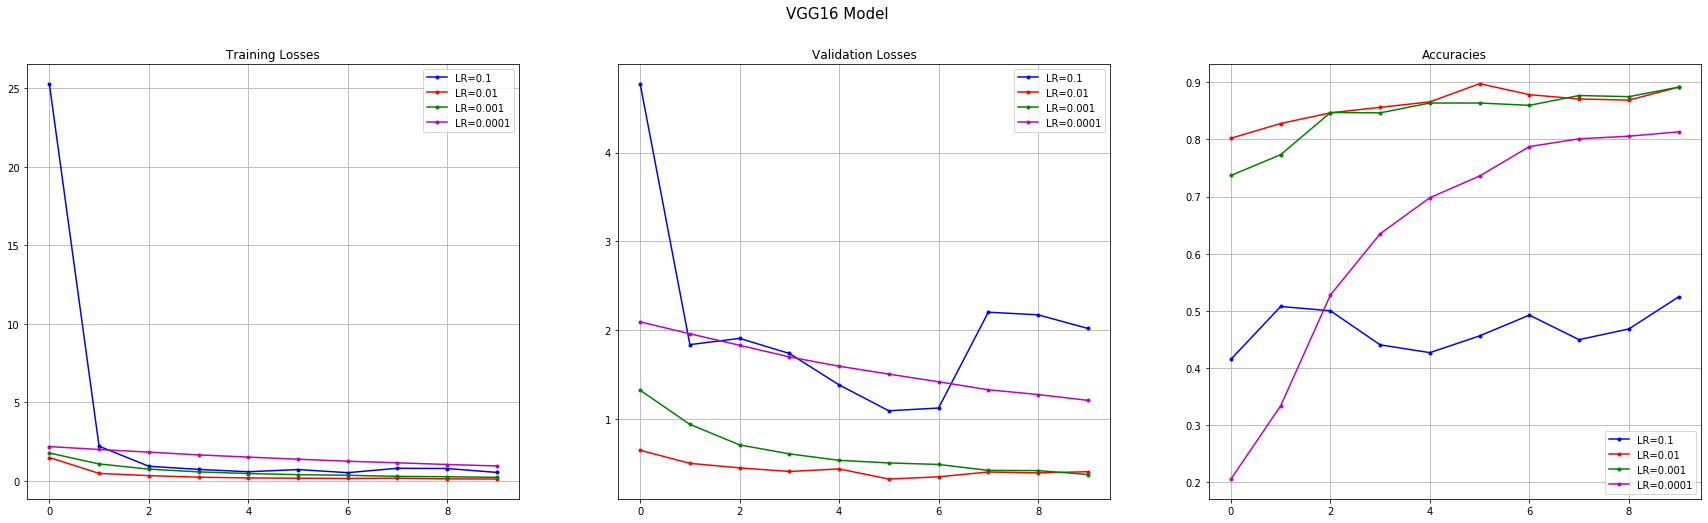

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,8))

f.suptitle('VGG16 Model', fontsize=15)

ax1.set_title('Training Losses')
ax1.plot(train_losses[0], 'b.-', label="LR=0.1")
ax1.plot(train_losses[1], 'r.-', label="LR=0.01")
ax1.plot(train_losses[2], 'g.-', label="LR=0.001")
ax1.plot(train_losses[3], 'm.-', label="LR=0.0001")
ax1.grid(True)
ax1.legend()

ax2.set_title('Validation Losses')
ax2.plot(val_losses[0], 'b.-', label="LR=0.1")
ax2.plot(val_losses[1], 'r.-', label="LR=0.01")
ax2.plot(val_losses[2], 'g.-', label="LR=0.001")
ax2.plot(val_losses[3], 'm.-', label="LR=0.0001")
ax2.grid(True)
ax2.legend()


ax3.set_title('Accuracies')
ax3.plot(accuracies[0], 'b.-', label="LR=0.1")
ax3.plot(accuracies[1], 'r.-', label="LR=0.01")
ax3.plot(accuracies[2], 'g.-', label="LR=0.001")
ax3.plot(accuracies[3], 'm.-', label="LR=0.0001")
ax3.grid(True)
ax3.legend()



# Dropout 

### Dropout is a method of preventing overfitting by ifnoring neurons in the training phase, with a given probability. 

### Values of 0, 0.1, 0.2, 0.5 were used. these we're selected to give an indication of the effectiveness of dropout on the dataset. 


### using only 10 epochs was not enough to give a good representation of epoch effect, so 20 were used on the second run. 


### Running 20 epochs gave a clear indication that a dropout of 0.2 was the most suitable, and so was used further.

In [0]:
dropouts = [0, 0.1, 0.2, 0.5]

validate_loader= test_loader

train_losses = []
val_losses = [] 
accuracies = [] 

for dropout in dropouts:

  model = models.vgg16(pretrained=True)

  # freeze layers
  for parameter in model.parameters():
      parameter.requires_grad = False

  # reshape classifier to data
  classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                          ('drop', nn.Dropout(p=dropout)),
                                          ('fc2', nn.Linear(5000, num_classes))
                                          )]))

  model.classifier = classifier

  print('========== DROPOUT = {} =========='.format(dropout))

  train_l, val_l, acc_l, cm, _ = train_model(model, num_epochs=10, learning_rate=0.01)
  train_losses.append(train_l) 
  val_losses.append(val_l) 
  accuracies.append(acc_l)
  

========== DROPOUT = 0 ==========
Epoch: 1/10..  Training Loss: 758.69593..  Validation Loss: 213.58283..  Validation Accuracy: 0.79798
Epoch: 2/10..  Training Loss: 134.46288..  Validation Loss: 124.42639..  Validation Accuracy: 0.80758
Epoch: 3/10..  Training Loss: 60.40295..  Validation Loss: 99.46431..  Validation Accuracy: 0.81111
Epoch: 4/10..  Training Loss: 32.80931..  Validation Loss: 58.40027..  Validation Accuracy: 0.82071
Epoch: 5/10..  Training Loss: 25.88132..  Validation Loss: 47.73333..  Validation Accuracy: 0.82071
Epoch: 6/10..  Training Loss: 23.37358..  Validation Loss: 77.56497..  Validation Accuracy: 0.81263
Epoch: 7/10..  Training Loss: 26.24346..  Validation Loss: 100.10583..  Validation Accuracy: 0.82778
Epoch: 8/10..  Training Loss: 26.91375..  Validation Loss: 111.89670..  Validation Accuracy: 0.77323
Epoch: 9/10..  Training Loss: 32.99817..  Validation Loss: 107.08164..  Validation Accuracy: 0.82071
Epoch: 10/10..  Training Loss: 37.44285..  Validation Loss:

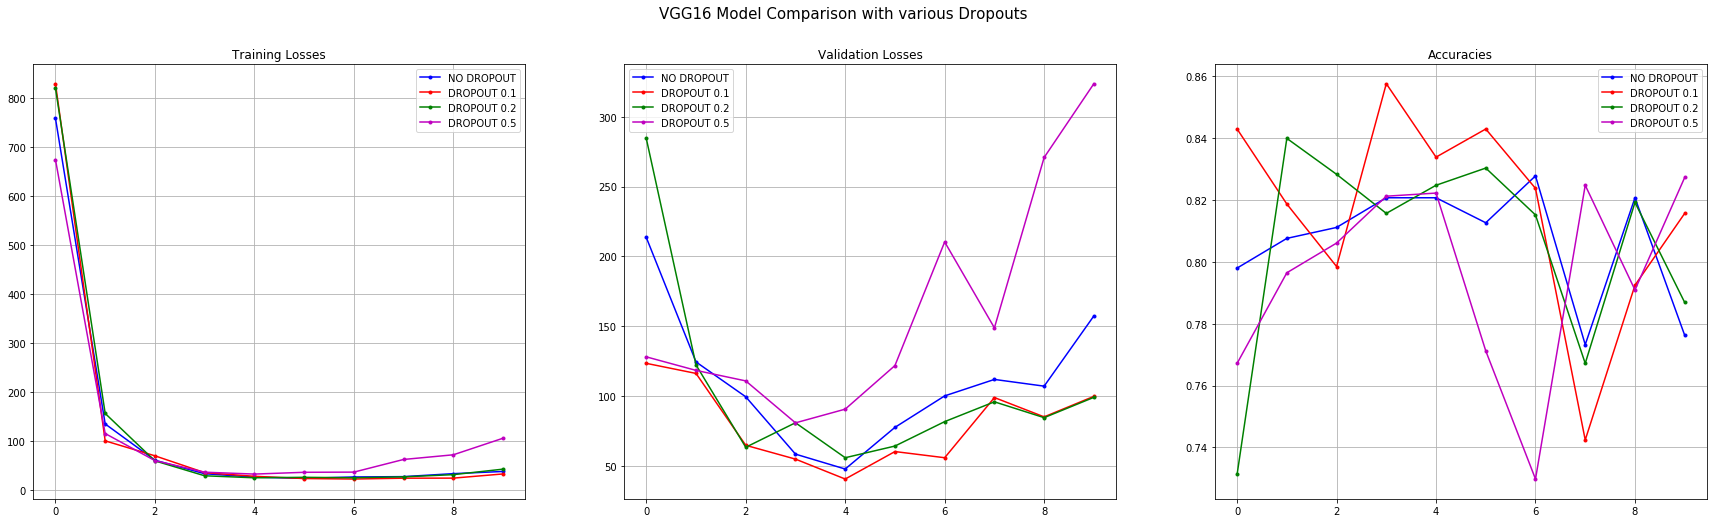

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,8))

f.suptitle('VGG16 Model Comparison with various Dropouts', fontsize=15)

ax1.set_title('Training Losses')
ax1.plot(train_losses[0], 'b.-', label="NO DROPOUT")
ax1.plot(train_losses[1], 'r.-', label="DROPOUT 0.1")
ax1.plot(train_losses[2], 'g.-', label="DROPOUT 0.2")
ax1.plot(train_losses[3], 'm.-', label="DROPOUT 0.5")

ax1.grid(True)
ax1.legend()

ax2.set_title('Validation Losses')
ax2.plot(val_losses[0], 'b.-', label="NO DROPOUT")
ax2.plot(val_losses[1], 'r.-', label="DROPOUT 0.1")
ax2.plot(val_losses[2], 'g.-', label="DROPOUT 0.2")
ax2.plot(val_losses[3], 'm.-', label="DROPOUT 0.5")

ax2.grid(True)
ax2.legend()


ax3.set_title('Accuracies')
ax3.plot(accuracies[0], 'b.-', label="NO DROPOUT")
ax3.plot(accuracies[1], 'r.-', label="DROPOUT 0.1")
ax3.plot(accuracies[2], 'g.-', label="DROPOUT 0.2")
ax3.plot(accuracies[3], 'm.-', label="DROPOUT 0.5")

ax3.grid(True)
ax3.legend()

In [0]:
dropouts = [0, 0.1, 0.2, 0.5]

validate_loader= test_loader

train_losses = []
val_losses = [] 
accuracies = [] 

for dropout in dropouts:

  model = models.vgg16(pretrained=True)

  # freeze layers
  for parameter in model.parameters():
      parameter.requires_grad = False

  # reshape classifier to data
  classifier = nn.Sequential(OrderedDict([('drop', nn.Dropout(p=dropout)),
                                          ('fc2', nn.Linear(5000, num_classes))]))

  model.classifier = classifier

  print('========== DROPOUT = {} =========='.format(dropout))

  train_l, val_l, acc_l, cm, _ = train_model(model, num_epochs=20, learning_rate=0.01)
  train_losses.append(train_l) 
  val_losses.append(val_l) 
  accuracies.append(acc_l)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



========== DROPOUT = 0 ==========
Epoch: 1/20..  Training Loss: 10020.67569..  Validation Loss: 4006.41691..  Validation Accuracy: 0.10000
Epoch: 2/20..  Training Loss: 3428.69092..  Validation Loss: 920.42360..  Validation Accuracy: 0.43485
Epoch: 3/20..  Training Loss: 1758.67917..  Validation Loss: 1501.48258..  Validation Accuracy: 0.53737
Epoch: 4/20..  Training Loss: 1407.93735..  Validation Loss: 940.63595..  Validation Accuracy: 0.67525
Epoch: 5/20..  Training Loss: 1157.12813..  Validation Loss: 797.02188..  Validation Accuracy: 0.76667
Epoch: 6/20..  Training Loss: 505.72201..  Validation Loss: 315.54231..  Validation Accuracy: 0.84949
Epoch: 7/20..  Training Loss: 438.98002..  Validation Loss: 334.18070..  Validation Accuracy: 0.84545
Epoch: 8/20..  Training Loss: 446.47732..  Validation Loss: 292.47186..  Validation Accuracy: 0.84899
Epoch: 9/20..  Training Loss: 353.76000..  Validation Loss: 550.40385..  Validation Accuracy: 0.79495
Epoch: 10/20..  Training Loss: 201.6269

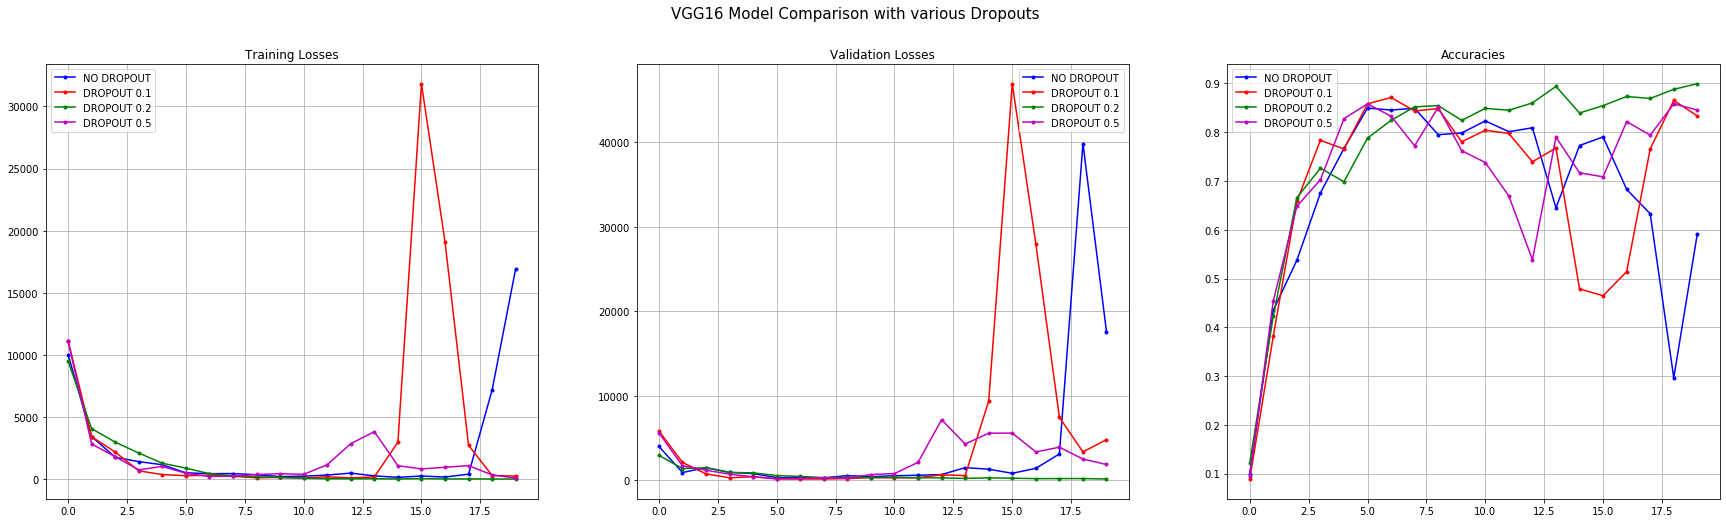

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,8))

f.suptitle('VGG16 Model Comparison with various Dropouts', fontsize=15)

ax1.set_title('Training Losses')
ax1.plot(train_losses[0], 'b.-', label="NO DROPOUT")
ax1.plot(train_losses[1], 'r.-', label="DROPOUT 0.1")
ax1.plot(train_losses[2], 'g.-', label="DROPOUT 0.2")
ax1.plot(train_losses[3], 'm.-', label="DROPOUT 0.5")

ax1.grid(True)
ax1.legend()

ax2.set_title('Validation Losses')
ax2.plot(val_losses[0], 'b.-', label="NO DROPOUT")
ax2.plot(val_losses[1], 'r.-', label="DROPOUT 0.1")
ax2.plot(val_losses[2], 'g.-', label="DROPOUT 0.2")
ax2.plot(val_losses[3], 'm.-', label="DROPOUT 0.5")

ax2.grid(True)
ax2.legend()


ax3.set_title('Accuracies')
ax3.plot(accuracies[0], 'b.-', label="NO DROPOUT")
ax3.plot(accuracies[1], 'r.-', label="DROPOUT 0.1")
ax3.plot(accuracies[2], 'g.-', label="DROPOUT 0.2")
ax3.plot(accuracies[3], 'm.-', label="DROPOUT 0.5")

ax3.grid(True)
ax3.legend()

# Frozen layers


### for the inital model, we only unfreeze the outermost layer, and so only this layer is trained on the dataset, whereas the rest are pre-trained on other huge datasets- provided by the model. The number of trainable layers was investigated by unfreezing the outer 2,5,10 and 20 layers.

### Unfreezing various outer layers does not seem to have a significant impact on the models performance, so they are all left frozen (except the outer layer as to begin with)

In [0]:
num_classes = 9
layers_to_unfreeze = [0,1,5,10,20]
num_parameters = 336

train_losses = []
val_losses = [] 
accuracies = [] 

for layer_num in layers_to_unfreeze:

  model = models.densenet121(pretrained=True)
  
  for i, parameter in enumerate(model.parameters()):
    if i < (num_parameters - layer_num):
      parameter.requires_grad = False

  model.classifier = nn.Sequential(OrderedDict([('fc',  nn.Linear(1024, num_classes)),
                                             ('drop', nn.Dropout(p=0.2))]))


  print('========== UNFROZEN_LAYERS = {} =========='.format(layer_num))

  train_l, val_l, acc_l, cm, _ = train_model(model, num_epochs=10, learning_rate=0.01)
  train_losses.append(train_l) 
  val_losses.append(val_l) 
  accuracies.append(acc_l)

========== UNFROZEN_LAYERS = 0 ==========
Epoch: 1/10..  Training Loss: 7.83902..  Validation Loss: 1.47156..  Validation Accuracy: 0.59242
Epoch: 2/10..  Training Loss: 2.52125..  Validation Loss: 0.94678..  Validation Accuracy: 0.68030
Epoch: 3/10..  Training Loss: 1.49280..  Validation Loss: 0.78516..  Validation Accuracy: 0.77424
Epoch: 4/10..  Training Loss: 1.07009..  Validation Loss: 0.66955..  Validation Accuracy: 0.77475
Epoch: 5/10..  Training Loss: 1.08778..  Validation Loss: 0.50398..  Validation Accuracy: 0.81111
Epoch: 6/10..  Training Loss: 1.00784..  Validation Loss: 0.46922..  Validation Accuracy: 0.85505
Epoch: 7/10..  Training Loss: 0.81053..  Validation Loss: 0.46042..  Validation Accuracy: 0.85707
Epoch: 8/10..  Training Loss: 1.12250..  Validation Loss: 0.51949..  Validation Accuracy: 0.85152
Epoch: 9/10..  Training Loss: 0.93486..  Validation Loss: 0.58115..  Validation Accuracy: 0.86465
Epoch: 10/10..  Training Loss: 0.60844..  Validation Loss: 0.38764..  Valida

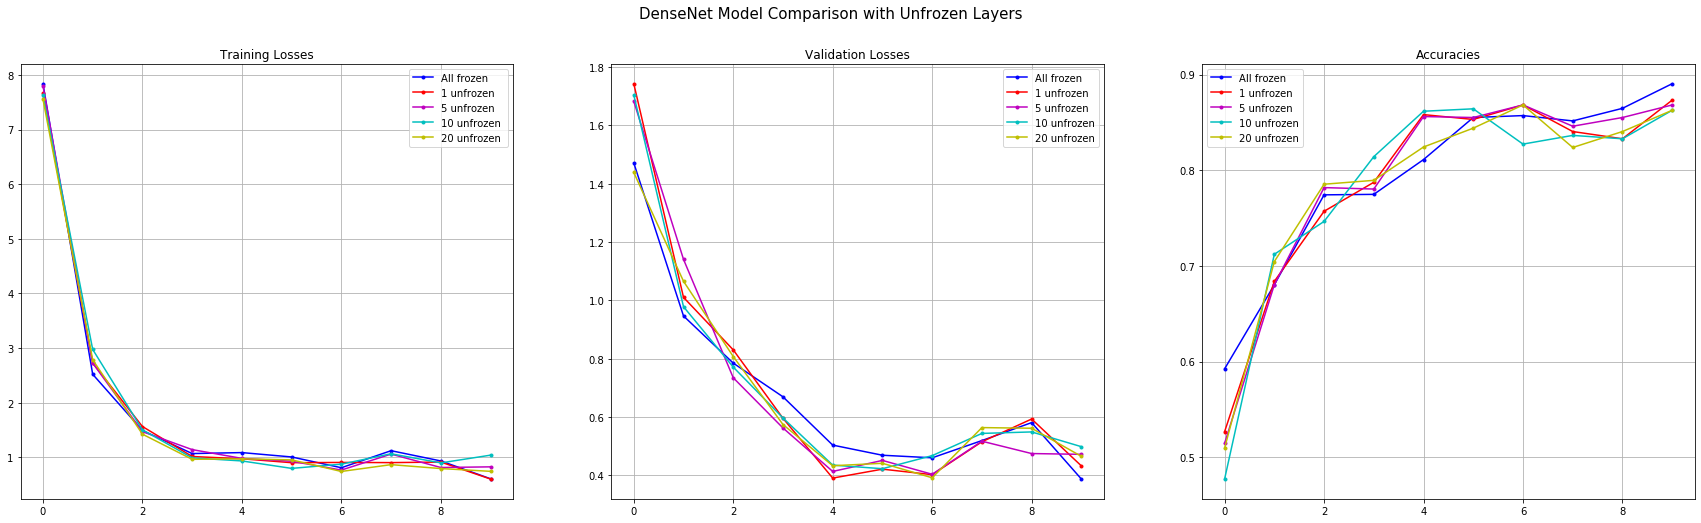

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,8))

f.suptitle('DenseNet Model Comparison with Unfrozen Layers', fontsize=15)

ax1.set_title('Training Losses')
ax1.plot(train_losses[0], 'b.-', label="All frozen")
ax1.plot(train_losses[1], 'r.-', label="1 unfrozen ")
ax1.plot(train_losses[2], 'm.-', label="5 unfrozen ")
ax1.plot(train_losses[3], 'c.-', label="10 unfrozen ")
ax1.plot(train_losses[4], 'y.-', label="20 unfrozen ")


ax1.grid(True)
ax1.legend()

ax2.set_title('Validation Losses')
ax2.plot(val_losses[0], 'b.-', label="All frozen")
ax2.plot(val_losses[1], 'r.-', label="1 unfrozen ")
ax2.plot(val_losses[2], 'm.-', label="5 unfrozen")
ax2.plot(val_losses[3], 'c.-', label="10 unfrozen")
ax2.plot(val_losses[4], 'y.-', label="20 unfrozen")


ax2.grid(True)
ax2.legend()


ax3.set_title('Accuracies')
ax3.plot(accuracies[0], 'b.-', label="All frozen")
ax3.plot(accuracies[1], 'r.-', label="1 unfrozen ")
ax3.plot(accuracies[2], 'm.-', label="5 unfrozen")
ax3.plot(accuracies[3], 'c.-', label="10 unfrozen")
ax3.plot(accuracies[4], 'y.-', label="20 unfrozen")


ax3.grid(True)
ax3.legend()

# L2 Regularisation

### L2 regularisation aims to prevent overfitting to a dataset by penalising highly complex models so they are more likely to perform well on unseen data.

### as we have a limited test set, and have signs of overfitting during tuning (a decrease in accuracy from epoch to epoch) this is necessary. 

### A number of penalties are tested which are applied to the optimizer during training. 

### The results are ambiguous, however LR=0.001 appears to give the most consistent results. 

### After this stage, the number of epochs were decreased to 10 as performance seemed to drastically decrease after 10 epochs. However on final runs, 10 epochs was not enough to sufficiently learn the model, and so 20 was used again. It is not clear what caused this. 


In [0]:
weights = [0, 0.1, 0.01, 0.001]

train_losses = []
val_losses = [] 
accuracies = [] 

for weight in weights:

  model = models.densenet121(pretrained=True)
  
  for parameter in model.parameters():
      parameter.requires_grad = False

  model.classifier = nn.Sequential(OrderedDict([('fc',  nn.Linear(1024, num_classes)),
                                             ('drop', nn.Dropout(p=0.2))]))


  print('========== L2 PENALTY = {} =========='.format(weight))

  train_l, val_l, acc_l, _, _= train_model(model, num_epochs=20, learning_rate=0.01, penalty=weight)
  train_losses.append(train_l) 
  val_losses.append(val_l) 
  accuracies.append(acc_l)
  

========== L2 PENALTY = 0 ==========
Epoch: 1/20..  Training Loss: 7.76072..  Validation Loss: 1.62822..  Validation Accuracy: 0.55455
Epoch: 2/20..  Training Loss: 2.63614..  Validation Loss: 0.97542..  Validation Accuracy: 0.69899
Epoch: 3/20..  Training Loss: 1.57869..  Validation Loss: 0.77106..  Validation Accuracy: 0.77980
Epoch: 4/20..  Training Loss: 1.06388..  Validation Loss: 0.61290..  Validation Accuracy: 0.75758
Epoch: 5/20..  Training Loss: 0.91012..  Validation Loss: 0.41316..  Validation Accuracy: 0.84848
Epoch: 6/20..  Training Loss: 0.88857..  Validation Loss: 0.43710..  Validation Accuracy: 0.83636
Epoch: 7/20..  Training Loss: 0.80460..  Validation Loss: 0.43575..  Validation Accuracy: 0.86263
Epoch: 8/20..  Training Loss: 0.74273..  Validation Loss: 0.49952..  Validation Accuracy: 0.83283
Epoch: 9/20..  Training Loss: 0.68397..  Validation Loss: 0.52271..  Validation Accuracy: 0.82727
Epoch: 10/20..  Training Loss: 0.64627..  Validation Loss: 0.50302..  Validation 

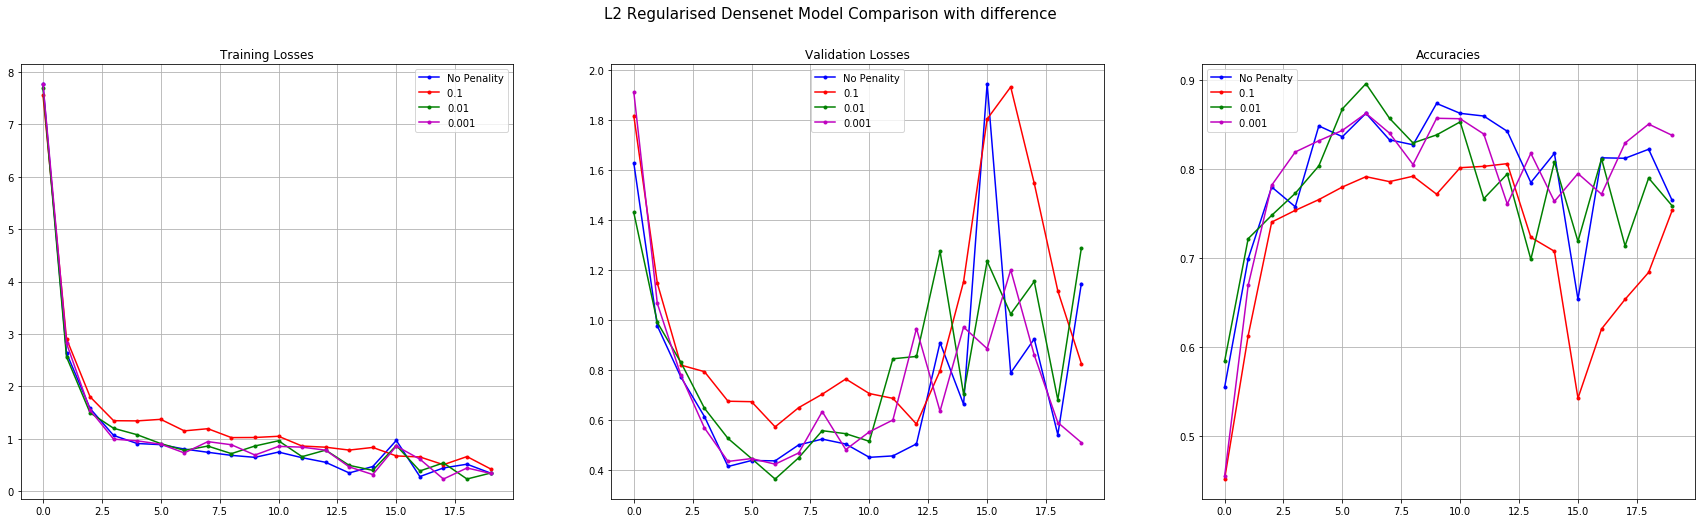

In [0]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(30,8))

f.suptitle('L2 Regularised Densenet Model Comparison with difference', fontsize=15)

ax1.set_title('Training Losses')
ax1.plot(train_losses[0], 'b.-', label="No Penality")
ax1.plot(train_losses[1], 'r.-', label="0.1 ")
ax1.plot(train_losses[2], 'g.-', label="0.01")
ax1.plot(train_losses[3], 'm.-', label="0.001")

ax1.grid(True)
ax1.legend()

ax2.set_title('Validation Losses')
ax2.plot(val_losses[0], 'b.-', label="No Penality")
ax2.plot(val_losses[1], 'r.-', label="0.1")
ax2.plot(val_losses[2], 'g.-', label="0.01")
ax2.plot(val_losses[3], 'm.-', label="0.001")

ax2.grid(True)
ax2.legend()


ax3.set_title('Accuracies')
ax3.plot(accuracies[0], 'b.-', label="No Penalty")
ax3.plot(accuracies[1], 'r.-', label="0.1 ")
ax3.plot(accuracies[2], 'g.-', label="0.01")
ax3.plot(accuracies[3], 'm.-', label="0.001 ")

ax3.grid(True)
ax3.legend()

# Evaluation

### Due to the limited data available, the test set was used to tune the model, and so we take the above model as our final classifier. 

### We found model performed better when assigned hyperparam/regularisation methods of: dropout=0.2, learning rate=0.01, and L2 regularisation=0.001. The number of frozen layers was not finetuned further.

### The final model achievies a final accuracy of 92%, which considering the large number of classes is quite high. 
 
### Although the final classifier acheives this good performance, the un-tuned densenet model also had a relatively high performance, exhibiting the power of such pre-trained models.  

### Looking at the models final confusion matrix below, we see 7 out of 9 characters are classified with over 90% accuracy (with the exception of Lois and Peter) however we see from the untuned densenet confusion matrix that these characters had particularly low classification precision to begin with. This could be a result of noise in the training images but should be investigated further. 






In [0]:
model = models.densenet121(pretrained=True)

  
for parameter in model.parameters():
    parameter.requires_grad = False

model.classifier = nn.Sequential(OrderedDict([('fc',  nn.Linear(1024, num_classes)),
                                             ('drop', nn.Dropout(p=0.2))]))



train_l, val_l, acc_l, cm, (y_true, y_pred) = train_model(model, num_epochs=20, learning_rate=0.01, penalty=0.001)

Epoch: 1/20..  Training Loss: 1.62529..  Validation Loss: 0.67032..  Validation Accuracy: 0.77817
Epoch: 2/20..  Training Loss: 0.45821..  Validation Loss: 0.58200..  Validation Accuracy: 0.83929
Epoch: 3/20..  Training Loss: 0.25771..  Validation Loss: 0.46010..  Validation Accuracy: 0.87460
Epoch: 4/20..  Training Loss: 0.15993..  Validation Loss: 0.46054..  Validation Accuracy: 0.85119
Epoch: 5/20..  Training Loss: 0.08886..  Validation Loss: 0.43286..  Validation Accuracy: 0.86865
Epoch: 6/20..  Training Loss: 0.03824..  Validation Loss: 0.38421..  Validation Accuracy: 0.86349
Epoch: 6/20..  Training Loss: 0.25026..  Validation Loss: 0.38017..  Validation Accuracy: 0.87024
Epoch: 7/20..  Training Loss: 0.21696..  Validation Loss: 0.40608..  Validation Accuracy: 0.87460
Epoch: 8/20..  Training Loss: 0.18650..  Validation Loss: 0.41802..  Validation Accuracy: 0.88135
Epoch: 9/20..  Training Loss: 0.13009..  Validation Loss: 0.38623..  Validation Accuracy: 0.84762
Epoch: 10/20..  Trai

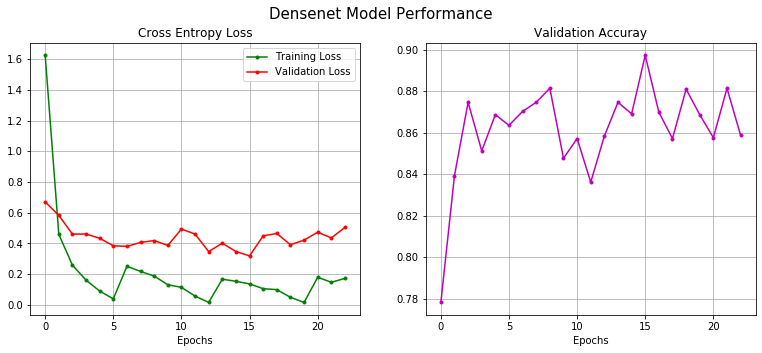

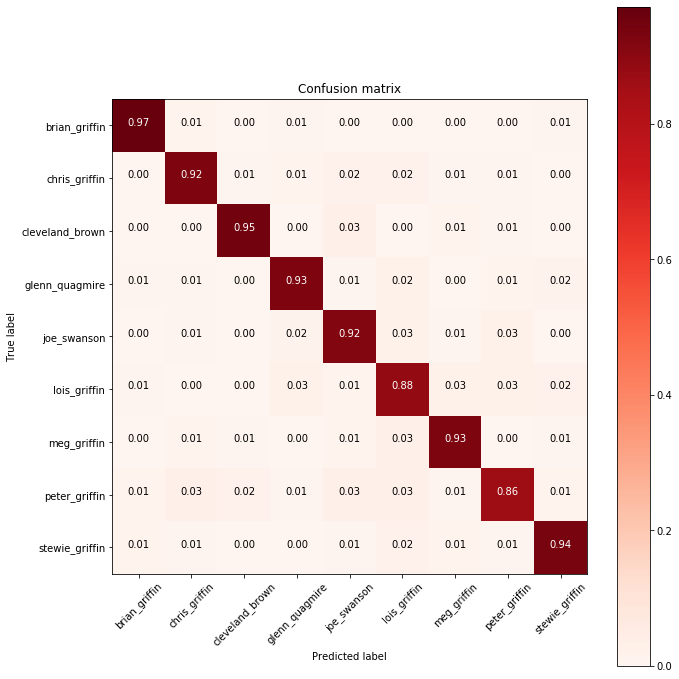

CLASSIFICATION REPORT FOR FINAL MODEL
                 precision    recall  f1-score   support

  brian_griffin       0.96      0.97      0.97       146
  chris_griffin       0.92      0.92      0.92       146
cleveland_brown       0.97      0.95      0.96       154
 glenn_quagmire       0.93      0.93      0.93       164
    joe_swanson       0.89      0.92      0.90       160
   lois_griffin       0.86      0.88      0.87       154
    meg_griffin       0.93      0.93      0.93       151
  peter_griffin       0.91      0.86      0.88       150
 stewie_griffin       0.94      0.94      0.94       155

       accuracy                           0.92      1380
      macro avg       0.92      0.92      0.92      1380
   weighted avg       0.92      0.92      0.92      1380



In [0]:
plot_performance(val_l, acc_l, "Densenet Model Performance", train_l)
plot_confusion_matrix(cm, test_data.classes, normalize=True)

print("CLASSIFICATION REPORT FOR FINAL MODEL")
print(classification_report(y_true, y_pred, target_names=test_data.classes))

# Prediction Visualisation 

The images are very distorted when printed out, which i was unable to fix. However below we can see the model is able to correctly classify 4 out of 5 random characters. 

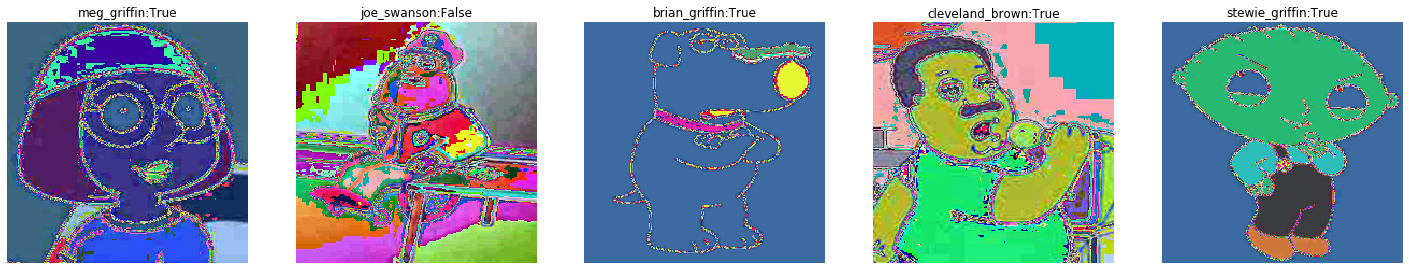

In [0]:
# prediction visualisation - 
# code taken code from https://towardsdatascience.com/how-to-train-an-image-classifier-in-pytorch-and-use-it-to-perform-basic-inference-on-single-images-99465a1e9bf5

def predict_image(image):
    image_tensor = transform1(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

def get_random_images(num):
    data = test_data
    classes = test_data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(25,20))

for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(idx_to_class[labels[ii]]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

# Conclusion


### Overall, the model is able to classify each of the 9 characters with high accuracy. 

### To improve this model to a standard where it would be useful in practice, more work should be done. 

### As the inital model before tuning was showed a high performance already, our search to optimise the model only slightly increased the performance. We may explore this in the future using more comprehensive methods in finetuning, such as Grid search cross validation. 

### While efforts were made to prevent overfitting by regularisation methods, the final model still showed some overfitting. This may be a result of an overcomplex model on simple image data, or a small test set. Future efforts should be made to address this by extending the dataset and using more comprehensive methods.

### Furthermore, the limited test/validation may not provide representative results of the classifiers performance - it would be useful to extend all datasets and generate a separate validation set.
